This notebook was created by Donna Faith Go.

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# change point detection
import roerich
from roerich.change_point import ChangePointDetectionClassifier
from autocpd.neuralnetwork import general_deep_nn, general_simple_nn

# ClaSP
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset

# hidden markov models
from hmmlearn.hmm import GaussianHMM

## Time Series Segmentation

## Change point detection (CPD)

In this module, I will try to implement Roerich. 
This is a python library for change point detection in time series data.
[This is the documentation](https://github.com/HSE-LAMBDA/roerich).

Notes for self:
1. `cps_true` is for the actual points where there is a change in the time series. `X` is for the points that they are supposed to predict.
2. options for `base_classifier`: 'logreg', 'qda', 'dt', 'rf', 'mlp', 'knn', 'nb'
3. options for `metric`:'klsym', 'pesym', 'jsd', 'mmd', 'fd'

### Sample Simulation

This simulation is from the documentation.

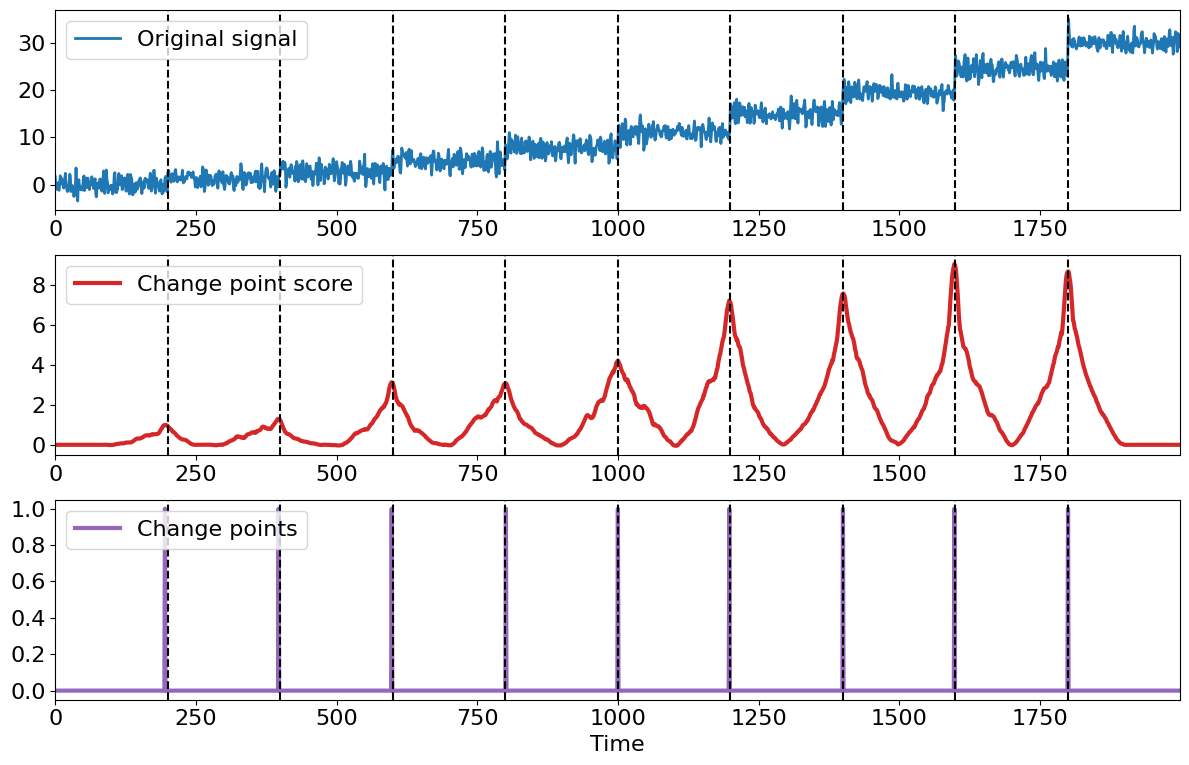

In [2]:
# generate time series
X, cps_true = roerich.generate_dataset(period=200, N_tot=2000)

# detection 
cpd = ChangePointDetectionClassifier(
    base_classifier='mlp', metric='klsym', window_size=100
)
score, cps_pred = cpd.predict(X)

# visualization
roerich.display(X, cps_true, score, cps_pred)

## Hidden Markov Models
Parameterized time series segmentation

Hidden Markov Models
- used to describe systems that transition between hidden states over time.
- each hidden state produces observable outputs according to specific probabilities.
- has three main parts: transition probabilities, emission probabilities, and initial probabilities.

transition probabilites: move between states  
emission probabilities: each state producing specific observations  
initial probabilities: starting in a particular state

**do a curciary check and see if they are interesting**  
bic baysian information criteria; parsimonuous; simplicity;  
aic brute force optimizing the fit quality

In [3]:
# data gathering
filepath = 'vix data.pkl'
with open(filepath, 'rb') as f:
    vix_data = pickle.load(f)

# adding more features
vix_data['returns'] = vix_data['^VIX'].diff(1)
vix_data.drop(index='2013-01-02', inplace=True)
vix_data['volatility'] = (
    vix_data['returns']
        .rolling(window=5)
        .std()
)

# note: would have been better if i can also include the range (high - low)

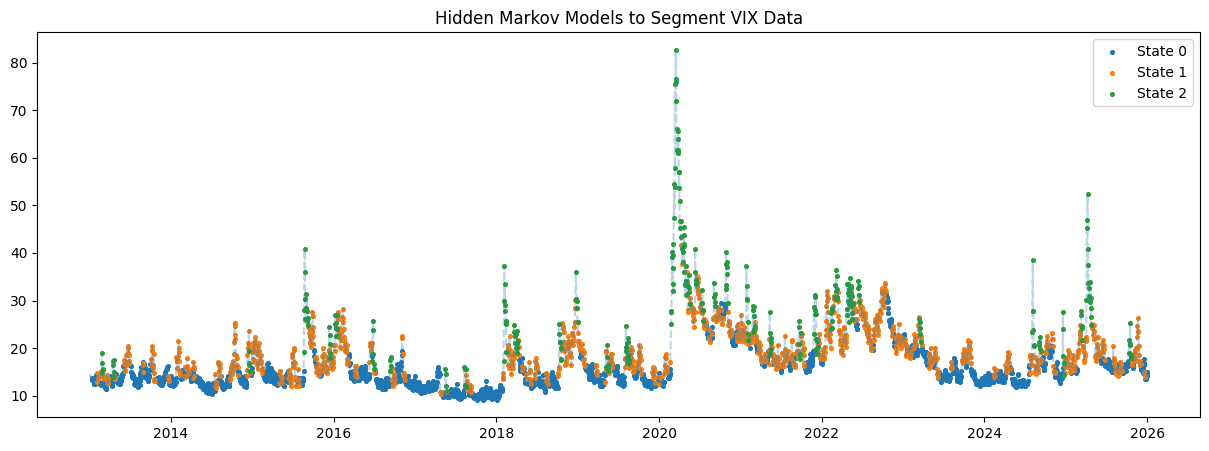

In [4]:
# feature extraction
features = vix_data[['returns', 'volatility']].dropna()
x = features.values

# gaussian HMM
model = GaussianHMM(
    n_components = 3, 
    covariance_type = 'full', 
    n_iter = 1000, 
    random_state = 42
)
model.fit(x)
hidden_states = model.predict(x)
features['state'] = hidden_states

# compare to original data
vix_data.loc[features.index, 'state'] = features['state']

# plotting
plt.figure(figsize=(15, 5))

for state in range(model.n_components):
    mask = vix_data['state'] == state
    plt.scatter(
        vix_data.index[mask], 
        vix_data['^VIX'][mask], 
        label=f'State {state}',
        s=7
    )

plt.plot(vix_data['^VIX'], alpha=0.3, linestyle='--')
plt.legend()
plt.title('Hidden Markov Models to Segment VIX Data')
plt.show()

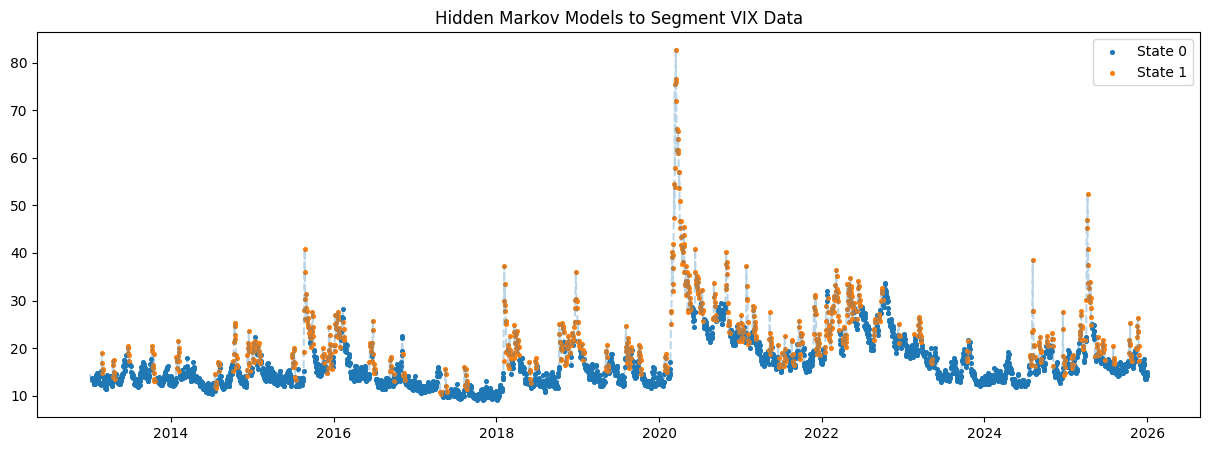

In [5]:
# feature extraction
features = vix_data[['returns', 'volatility']].dropna()
x = features.values

# gaussian HMM
model = GaussianHMM(
    n_components = 2, 
    covariance_type = 'full', 
    n_iter = 1000, 
    random_state = 42
)
model.fit(x)
hidden_states = model.predict(x)
features['state'] = hidden_states

# compare to original data
vix_data.loc[features.index, 'state'] = features['state']

# plotting
plt.figure(figsize=(15, 5))

for state in range(model.n_components):
    mask = vix_data['state'] == state
    plt.scatter(
        vix_data.index[mask], 
        vix_data['^VIX'][mask], 
        label=f'State {state}',
        s=7
    )

plt.plot(vix_data['^VIX'], alpha=0.3, linestyle='--')
plt.legend()
plt.title('Hidden Markov Models to Segment VIX Data')
plt.show()

## ClaSP


For this section, I referred to [this paper](https://uh.primo.exlibrisgroup.com/permalink/01UHO_INST/1j911kt/cdi_proquest_journals_3248896917).
Their code is publicly available [here](https://github.com/ermshaua/time-series-segmentation-benchmark/tree/main).

Note to self:
- Parameter-free time series segmentation

In [ ]:
# # setting up model
# clasp = BinaryClaSPSegmentation(window_size=100)

# # fit predict
# clasp.fit_predict(vix_data['returns'].values)
# clasp.plot(heading="Segmentation of VIX returns", 
#            ts_name="VIX returns")

## Learnings

gikapoy nako huhuhu

## References

Research articles:
1. [Unsupervised Time Series Segmentation: A Survey on Recent Advances](https://www.sciopen.com/article/10.32604/cmc.2024.054061)
2. [Stylised facts of financial time series and hidden Markov models in continuous time](https://www-tandfonline-com.ezproxy.lib.uh.edu/doi/pdf/10.1080/14697688.2015.1004801) please read this later
3. [Automatic change-point detection in time series via deep learning](https://uh.primo.exlibrisgroup.com/permalink/01UHO_INST/1j911kt/cdi_proquest_journals_3248896917) did not pursue this because training the neural network requires labelled data. 
4. [ClaSP: parameter-free time series segmentation](https://uh.primo.exlibrisgroup.com/permalink/01UHO_INST/1j911kt/cdi_scopus_primary_2_s2_0_85148072623)

Medium articles:
1. [Change Point Detection in Time Series](https://medium.com/@sztistvan/change-point-detection-in-time-series-using-chatgpt-22cc9172a130)
2. [Leveraging Hidden Markov Models for Regime-Based Segmentation in Time-Series](https://medium.com/@khizarimran/leveraging-hidden-markov-models-for-regime-based-segmentation-in-time-series-3900aa549451)
3. [Hidden Markov Models Explained with a Real Life Example and Python code](https://medium.com/data-science/hidden-markov-models-explained-with-a-real-life-example-and-python-code-2df2a7956d65)
4. [Understanding Variational Inference](https://medium.com/@msuhail153/understanding-variational-inference-ae119f9bc3ed)

Code Documentation:
1. [HMMLearn](https://hmmlearn.readthedocs.io/en/stable/tutorial.html)

GitHub
1. [time series segmentation papers](https://github.com/lzz19980125/awesome-time-series-segmentation-papers)